# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 0.2. DEFINE VARIABLES 

In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
DATA_PATH = 'drive/MyDrive/'

ROUND = 1 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '28080'
PROJECT_CODE = 'CS412234047baf096' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [4]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf = pd.read_csv('training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

tweet_id isPolitical
0     1418828259614236672          No
1     1424439289753083911          No
2     1354305766644199427         Yes
3     1438890637282193408         Yes
4     1397543048452591616          No
...                   ...         ...
2995  1416144676990722053         Yes
2996  1466793383788220421         Yes
2997  1448350353439744003         Yes
2998  1423327989044072453         Yes
2999  1417253447347458052          No

[3000 rows x 2 columns]

In [5]:
trainingTweetDf.isPolitical.value_counts()

No     1509
Yes    1491
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [6]:
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv('training-user.csv')
trainingUserDf

screen_name     isBot
0        faracyaziyor        No
1          elifgibirt        No
2        buocguldurdu        No
3        __baba1yaga_        No
4     hakanyilmazcebi        No
...               ...       ...
2995  kupakralicesi53        No
2996  muhamme44063672        No
2997         galaopta  Not sure
2998           hygea0        No
2999        ama_ensar        No

[3000 rows x 2 columns]

In [7]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [8]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/AnnotationTwitterTR/reports/report_CS412234047baf096.html


## 1. Landing Page

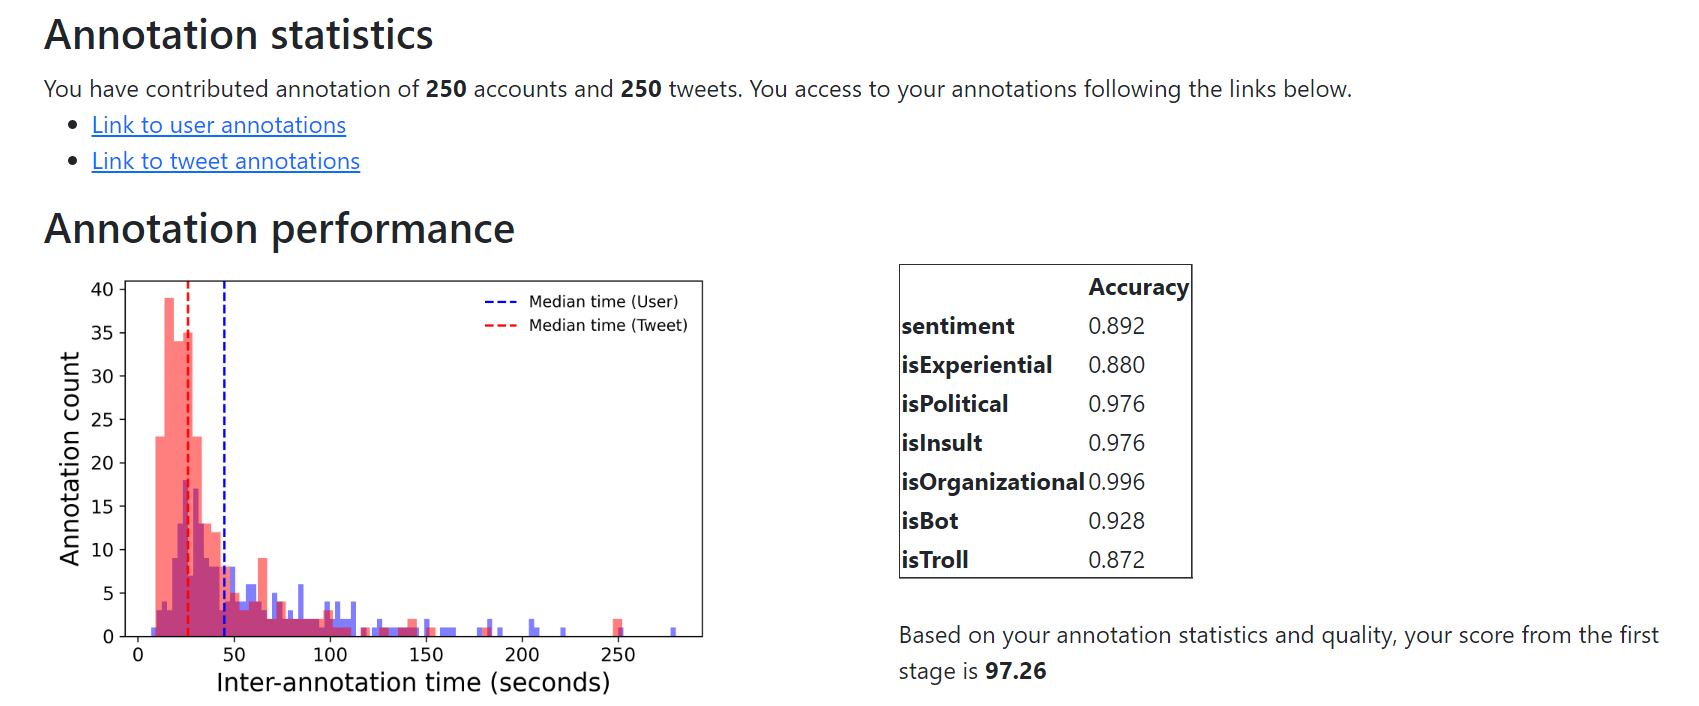

In [9]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

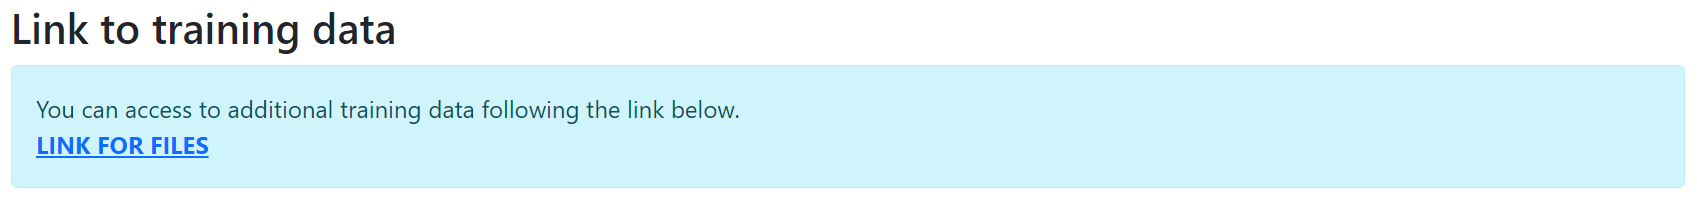

In [10]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

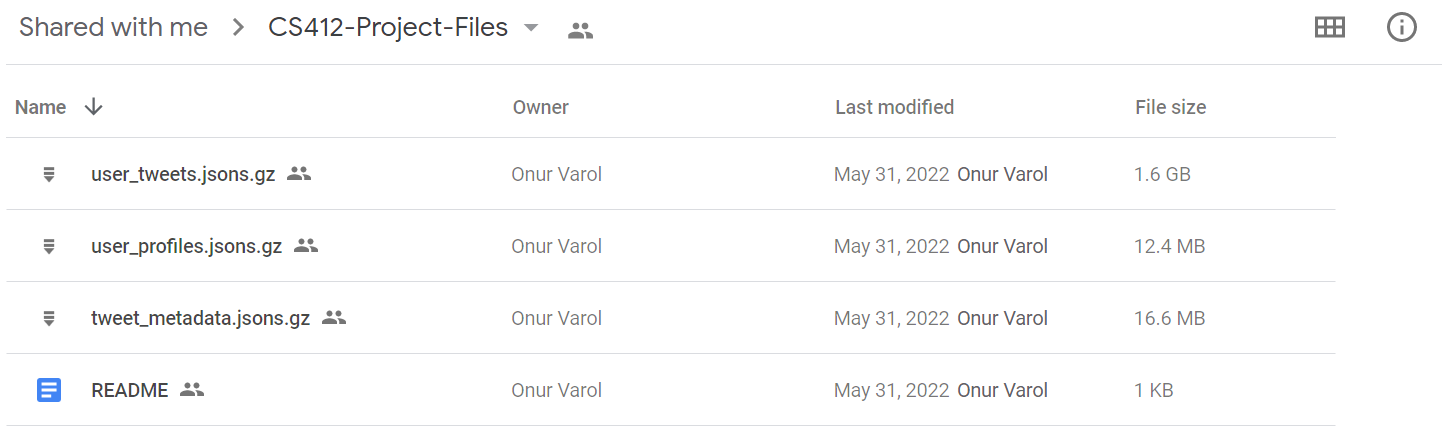

In [11]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [12]:
PATH_TO_DOWNLOADED = ''

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [13]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [14]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [15]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [16]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [17]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [18]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [19]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener','erdoğan' 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag', 'ekrem_imamoglu', 'AK Parti','HDP','AKP', 'CHP',"atama","İYİ Parti","MHP","suleymansoylu",
                        "Meral Akşener","dbdevletbahceli",'devletbahceli',"Cumhurbaşkanımız", 'bay kemal', 'bekir bozdağ','Bahçeli','drfahrettinkoca','bybekirbozdag', 'devlet', 'politik', 'meclis',"Recep Tayyip Erdoğan",'Recep Tayyip Erdogan',"CHP","Süleyman Soylu","eyt"
                        "Devlet Bahçeli","Mansur Yavaş","tcbestepe","varank","melihgokcek","Vuk359",'Seçim', 'atama', "kyk","Sayın"]
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [20]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [21]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
              'total_interactions':[]}


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)

In [22]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

tweet_id  is_retweet retweeted_username  \
0      1416676063216799754           0               None   
1      1445677417150889986           1     ekrem_imamoglu   
2      1456638729620230149           1          yenisafak   
3      1451295314074341381           1     ekrem_imamoglu   
4      1440610747134844929           1          umitozdag   
...                    ...         ...                ...   
32997  1439639972177489926           1     deryayanikashb   
32998  1467519965473423362           1      kilicdarogluk   
32999  1423666826282668035           1          rterdogan   
33000  1417025303894007810           1          thetubaca   
33001  1418594874836848649           1          kasapoglu   

                                                    text  num_mentions  \
0      @Murat_ide @meral_aksener Bu bu büyük millet k...             2   
1      RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...             1   
2      RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...             1   
3      RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...             1   
4      RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...             1   
...                                                  ...           ...   
32997  RT @deryayanikashb: AK Parti Çanakkale İl Başk...             1   
32998  RT @kilicdarogluk: Türkiye Barolar Birliği 36....             1   
32999  RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...             1   
33000  RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...             3   
33001  RT @kasapoglu: Haydi Bismillah! #Tokyo2020’dek...             1   

       num_hashtags  num_retweets  num_favorites              user_id  \
0                 0             0              0  1368124787009216516   
1                 0          6706              0  1263130166961864705   
2                 0          1545              0           2958652582   
3                 0          7470              0  1447285927471112194   
4                 0           745              0            379944275   
...             ...           ...            ...                  ...   
32997             0            48              0            165689533   
32998             0          4438              0            408719429   
32999             0         14311              0  1004379711890485248   
33000             0            16              0  1049663929348222985   
33001             1           439              0   719802634819997696   

      user_screen_name                                   user_description  \
0      murtaza91000878                                                      
1      hasanak11633015                                       64 Jahre alt   
2          buyukdogu58                                Katılıyorum: RT+FAV   
3            gskaya444                                                      
4            cerenncan                                                      
...                ...                                                ...   
32997      sezayicimen  İst.Aydın Üniversitesi Mahalli İdareler ve Yer...   
32998         sdiplen1       Hepimiz birileri için kurallarımızı çiğnedik   
32999       soguzsoylu                   AK Parti Yumurtalık İlçe Başkanı   
33000      mhmt_ckmk04     667 ile yılları çalınan gurebadan bir garip...   
33001       trguresfed  Turkish Wrestling Federation Official twitter ...   

       num_political_entities  total_interactions  
0                           1                   0  
1                           1                6706  
2                           2                1545  
3                           1                7470  
4                           1                 745  
...                       ...                 ...  
32997                       1                  48  
32998                       1                4438  
32999                       1               14311  
33000                       0                  16  
33001                 

## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [23]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [24]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [25]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [26]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[]}
i=0
with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        if(i<5):
          print(line)
          i=i+1
        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

{'id': 1195008426784493571, 'id_str': '1195008426784493571', 'name': 'Mesut Demir🎨', 'screen_name': 'grslsntlarogrt', 'location': 'Mardin', 'description': 'Görsel Sanatlar Öğretmeni 🎨', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 2527, 'friends_count': 2609, 'listed_count': 0, 'created_at': 'Thu Nov 14 15:59:52 +0000 2019', 'favourites_count': 8928, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 10515, 'lang': None, 'status': {'created_at': 'Sun May 15 07:38:18 +0000 2022', 'id': 1525742352412844033, 'id_str': '1525742352412844033', 'text': 'Bizi neden karanlıkta bırakıyorsun!\n@tcmeb\n\n#Atamasiz74Gun', 'truncated': False, 'entities': {'hashtags': [{'text': 'Atamasiz74Gun', 'indices': [44, 58]}], 'symbols': [], 'user_mentions': [{'screen_name': 'tcmeb', 'name': 'Millî Eğitim Bakanlığı', 'id': 2164603921, 'id_str': '2164603921', 'indices': [36, 42]}], 'urls': []}, 'source': '<a href="ht

In [27]:
dfBot = pd.DataFrame(dfBot)
dfBot

user_id                                         user_name  \
0      1195008426784493571                                      Mesut Demir🎨   
1       912738858437050369                                       AdnanToprak   
2               2490178497  Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍   
3                161774611                             Tek Kişilik Muhalefet   
4      1349294559797370881                                           Muti_79   
...                    ...                                               ...   
31816            467645507                           T.C. İçişleri Bakanlığı   
31817  1246020601996816385                                            tuncay   
31818            601097854                          GMG Kastamonuspor Kulübü   
31819            356064164                                           Show TV   
31820   995985841368510464                                             Hocca   

      user_screen_name                user_location  \
0       grslsntlarogrt                       Mardin   
1        adnantoprak46                      Türkiye   
2            oykunejla                        izmir   
3        yalaaaaannnnn                                
4              muti_79              Ankara, Türkiye   
...                ...                          ...   
31816      tc_icisleri                      Türkiye   
31817      tuncayyilmz               Gebze, Türkiye   
31818   gmgkastamonusk                    Kastamonu   
31819           showtv            İstanbul, Türkiye   
31820   hocca_official  Manhattan, NY (Wall Street)   

                                        user_description  \
0                            Görsel Sanatlar Öğretmeni 🎨   
1                                                          
2      Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...   
3                           Hüloğcular lütfen uzan durun   
4                                                          
...                                                  ...   
31816  T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...   
31817                                  her şeyimi buldum   
31818  GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...   
31819  Show TV Resmi Twitter Profili https://t.co/d0g...   
31820  MİLYONERLER KULÜBÜ\nRobotlara fısıldayan ADAM😎...   

       user_followers_count  user_friends_count  description_len  \
0                      2527                2609               27   
1                      7527                6755                0   
2                      8819                8591              159   
3                       284                1352               28   
4                      3866                3937                0   
...                     ...                 ...              ...   
31816               2408670                  29              119   
31817                  8191                8183               17   
31818                  9323                  20               82   
31819               1355456                 111              101   
31820                 67674                 169              114   

       followers_to_all_ratio  
0                    0.492017  
1                    0.527027  
2                    0.506548  
3                    0.173594  
4                    0.495450  
...                       ...  
31816                0.999988  
31817                0.500244  
31818                0.997859  
31819                0.999918  
31820                0.997509  

[31821 rows x 9 columns]

### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [28]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [29]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

In [30]:
def get_totalhashtagsandmentions(line):
    tweets=line["tweets"]
    if(len(tweets)==0):
      return 0
    count=0
    for i in tweets:
      count+=i["text"].count("#")+i["text"].count("@")
    return count/len(tweets)

In [31]:
def tweet_number_perday(line) :
  dict = {}
  for i in range(len(line['tweets'])) :
    arr = line['tweets'][i]['created_at'].split(' ')
    day = arr[1] + ' ' + arr[2] + ' ' + arr[5]
    if day in dict:
      dict[day] += 1
    else :
      dict[day] = 0
  
  sum = 0
  for key in dict :
    sum += dict[key]
  if(len(dict) == 0 ) :
    return 0

  return sum/len(dict)

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [32]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
               'mention_and_hashtagcount':[],
               'tweets_per_day':[]}

i = 0
x=""
with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        mention_and_hashtagcount = get_totalhashtagsandmentions(line)
        dfBotTweets['mention_and_hashtagcount'].append(mention_and_hashtagcount)

        tweets_per_day = tweet_number_perday(line)
        dfBotTweets['tweets_per_day'].append(tweets_per_day)
        i += 1
        if(i==100):
          x=line

        if i % 1000 == 0:
          print(i)
print(x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
{'tweets': [{'created_at': 'Fri May 13 06:59:13 +0000 2022', 'id': 1525007743526047744, 'id_str': '1525007743526047744', 'text': '@yilmaznazif 2018👉 40 bin atama+puanların 2 yıl geçerliliği\n2019👉 40 bin atama+puanların 2 yıl geçerliliği\n\n2020👉 2… https://t.co/cBVCm2MWDQ', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'yilmaznazif', 'name': 'Nazif Yılmaz', 'id': 358685923, 'id_str': '358685923', 'indices': [0, 12]}], 'urls': [{'url': 'https://t.co/cBVCm2MWDQ', 'expanded_url': 'https://twitter.com/i/web/status/1525007743526047744', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': 1524831424519491600, 'in_reply_to_status_id_str': '1

In [33]:
print(json.dumps(x, indent=4, sort_keys=True))

{
    "tweets": [
        {
            "contributors": null,
            "coordinates": null,
            "created_at": "Fri May 13 06:59:13 +0000 2022",
            "entities": {
                "hashtags": [],
                "symbols": [],
                "urls": [
                    {
                        "display_url": "twitter.com/i/web/status/1\u2026",
                        "expanded_url": "https://twitter.com/i/web/status/1525007743526047744",
                        "indices": [
                            117,
                            140
                        ],
                        "url": "https://t.co/cBVCm2MWDQ"
                    }
                ],
                "user_mentions": [
                    {
                        "id": 358685923,
                        "id_str": "358685923",
                        "indices": [
                            0,
                            12
                        ],
                        "name": "Nazif 

In [34]:
dfBotTweets1 = pd.DataFrame.from_dict(dfBotTweets, orient='index')
dfBotTweets1 = dfBotTweets1.transpose()
dfBotTweets1

user_id retweet_total_ratio num_median_favorites  \
0               1044821071                0.09                 57.0   
1               1086355147            0.172973                 10.0   
2                205625453                 0.0                  9.0   
3      1382717948092157953            0.356784                  0.0   
4      1302055645307375618            0.646154                  0.0   
...                    ...                 ...                  ...   
29901           1865050056            0.890411                  0.0   
29902  1336329028324577281             0.78392                  0.0   
29903  1214219054329675777            0.970588                  0.0   
29904            310390437               0.875                  0.0   
29905  1284767643459899392            0.949749                  0.0   

      num_of_tweets mention_and_hashtagcount tweets_per_day  
0              None                     0.31       0.574803  
1              None                 0.427027       0.193548  
2              None                     0.13      32.333333  
3              None                 1.462312       5.862069  
4              None                 1.564103          7.125  
...             ...                      ...            ...  
29901          None                 2.561644          8.125  
29902          None                 1.713568       2.901961  
29903          None                 1.335294      55.666667  
29904          None                     1.07      32.333333  
29905          None                 1.386935       2.209677  

[29906 rows x 6 columns]

### 1.2.3. Merge dfBot and dfBotTweets

In [35]:
dfBotAll = dfBot.merge(dfBotTweets1)

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

user_id                                         user_name  \
0      1195008426784493571                                      Mesut Demir🎨   
1       912738858437050369                                       AdnanToprak   
2               2490178497  Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍   
3      1349294559797370881                                           Muti_79   
4      1327926627964162048                                  Servet Enustekin   
...                    ...                                               ...   
29901            467645507                           T.C. İçişleri Bakanlığı   
29902  1246020601996816385                                            tuncay   
29903            601097854                          GMG Kastamonuspor Kulübü   
29904            356064164                                           Show TV   
29905   995985841368510464                                             Hocca   

      user_screen_name                user_location  \
0       grslsntlarogrt                       Mardin   
1        adnantoprak46                      Türkiye   
2            oykunejla                        izmir   
3              muti_79              Ankara, Türkiye   
4               ay3613                                
...                ...                          ...   
29901      tc_icisleri                      Türkiye   
29902      tuncayyilmz               Gebze, Türkiye   
29903   gmgkastamonusk                    Kastamonu   
29904           showtv            İstanbul, Türkiye   
29905   hocca_official  Manhattan, NY (Wall Street)   

                                        user_description  \
0                            Görsel Sanatlar Öğretmeni 🎨   
1                                                          
2      Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...   
3                                                          
4                                  🇹🇷♥️🇹🇷♥️🇹🇷 Bitlis'li.   
...                                                  ...   
29901  T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...   
29902                                  her şeyimi buldum   
29903  GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...   
29904  Show TV Resmi Twitter Profili https://t.co/d0g...   
29905  MİLYONERLER KULÜBÜ\nRobotlara fısıldayan ADAM😎...   

       user_followers_count  user_friends_count  description_len  \
0                      2527                2609               27   
1                      7527                6755                0   
2                      8819                8591              159   
3                      3866                3937                0   
4                      4949                5172               21   
...                     ...                 ...              ...   
29901               2408670                  29              119   
29902                  8191                8183               17   
29903                  9323                  20               82   
29904               1355456                 111              101   
29905                 67674                 169              114   

       followers_to_all_ratio  retweet_total_ratio  num_median_favorites  \
0                    0.492017             0.060000                   1.0   
1                    0.527027             0.200000                 107.0   
2                    0.506548             0.230000                   1.0   
3                    0.495450             1.000000                   0.0   
4                    0.488983             0.291457                   1.0   
...                       ...                  ...                   ...   
29901                0.999988             0.735000                   0.0   
29902                0.500244             0.020000                   1.0   
29903                0.997859             0.000000                  24.0   
29904                0.999918             0.000000                  76.5   
29905                0.

# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [36]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

print(dfPoliticalAll_train.loc[(dfPoliticalAll_train["isPolitical"]!="Yes") & (dfPoliticalAll_train["isPolitical"]!="No")])

Empty DataFrame
Columns: [tweet_id, is_retweet, retweeted_username, text, num_mentions, num_hashtags, num_retweets, num_favorites, user_id, user_screen_name, user_description, num_political_entities, total_interactions, isPolitical]
Index: []


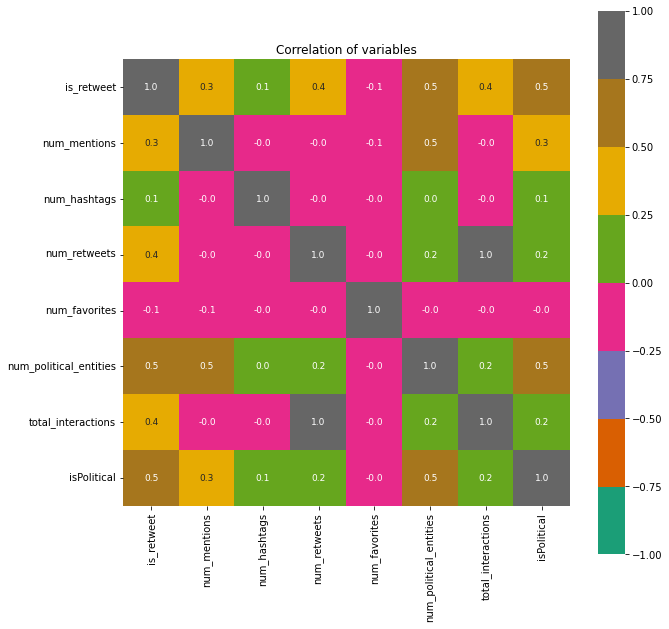

In [37]:
#Converting 'Yes' and 'No' to 1 and 0, respectively
dropped_dfPoliticalAll_train=dfPoliticalAll_train
dropped_dfPoliticalAll_train['isPolitical'] = dropped_dfPoliticalAll_train['isPolitical'].map({'Yes':1 ,'No':0})

dropped_dfPoliticalAll_train.head(5)

#In this part, we found the correlations between variables by using heatmap
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title('Correlation of variables')
dropped_dfPoliticalAll_train = dropped_dfPoliticalAll_train.drop(['tweet_id','retweeted_username', 'text','user_id','user_description','user_screen_name'], axis = 1).corr()
sns.heatmap(dropped_dfPoliticalAll_train, center=0, vmax=1, vmin=-1, annot = True, annot_kws = {'size':9},fmt='.1f',square=True,  cmap='Dark2')
plt.show()

### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [38]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags',"is_retweet"]]
y = dfPoliticalAll_train['isPolitical']

### 2.1.3. Train - validation split

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)


### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
best_accuracy_score= 0;

In [41]:
from sklearn.neighbors import KNeighborsClassifier
neighbors=range(1,40,1)
acc_scores=[]
for i in neighbors:
  dtc_bot= KNeighborsClassifier(n_neighbors=i)
  dtc_bot.fit(X_train, y_train)

  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_neighbor= neighbors[acc_scores.index(max(acc_scores))]
dtc_bot = KNeighborsClassifier(n_neighbors=best_neighbor)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=best_neighbor

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.24 Accuracy Score: 0.76 
 Confusion Matrix: 
 [[236  50]
 [ 94 220]] 



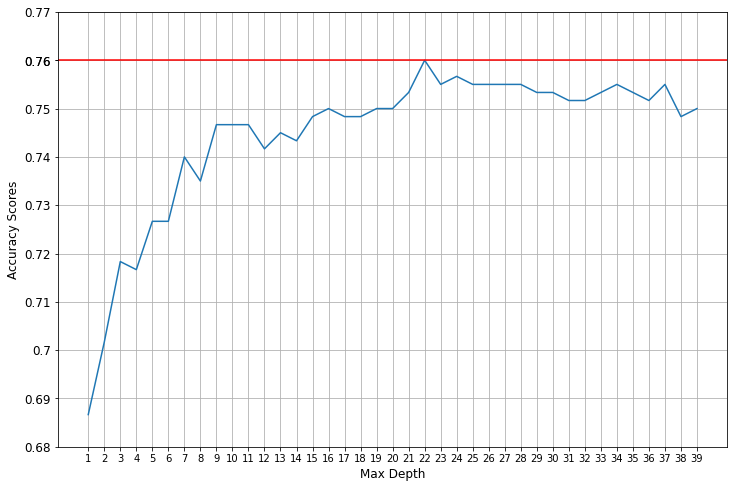

In [42]:
plt.figure(figsize=(12,8))
plt.plot(neighbors,acc_scores)
plt.axhline(max(acc_scores),color="red")

locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(acc_scores))
locs2= [round(num, 2) for num in locs2]

plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(neighbors, neighbors,fontsize=10)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)

plt.show()

In [43]:
from sklearn.tree import DecisionTreeClassifier


max_depths=range(3,20)
acc_scores=[]
for i in max_depths:
  # create an instance
  dtc_bot = DecisionTreeClassifier(max_depth=i)
  # fit your model
  dtc_bot.fit(X_train, y_train)
  # make predictions
  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_max_depth= max_depths[acc_scores.index(max(acc_scores))]
dtc_bot = DecisionTreeClassifier(max_depth=best_max_depth)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.20666666666666667 Accuracy Score: 0.7933333333333333 
 Confusion Matrix: 
 [[257  29]
 [ 95 219]] 



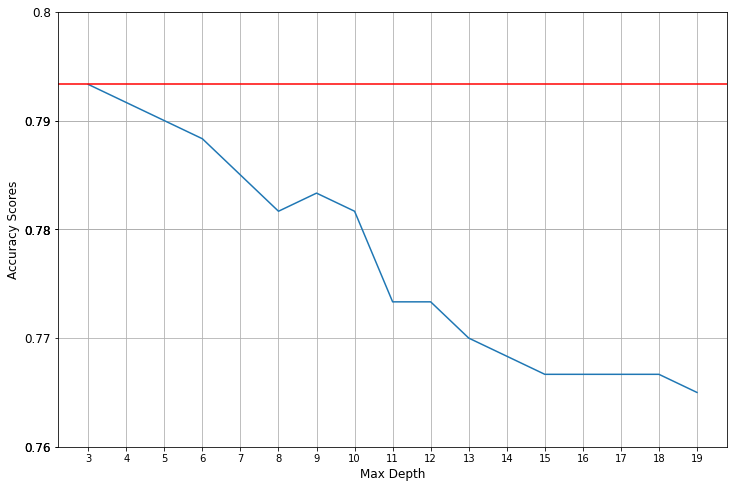

In [44]:
plt.figure(figsize=(12,8))
plt.plot(max_depths,acc_scores)
plt.axhline(max(acc_scores),color="red")

locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(acc_scores))
locs2= [round(num, 2) for num in locs2]

plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(max_depths, max_depths,fontsize=10)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)

plt.show()

In [45]:
from sklearn.linear_model import LogisticRegression

iters=range(50,100)
acc_scores=[]
for i in iters:
  # create an instance
  dtc_bot = LogisticRegression(max_iter=i)
  # fit your model
  dtc_bot.fit(X_train, y_train)
  # make predictions
  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_max_iter= iters[acc_scores.index(max(acc_scores))]
dtc_bot = LogisticRegression(max_iter=best_max_iter)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)

if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


MSE: 0.20666666666666667 Accuracy Score: 0.7933333333333333 
 Confusion Matrix: 
 [[257  29]
 [ 95 219]] 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


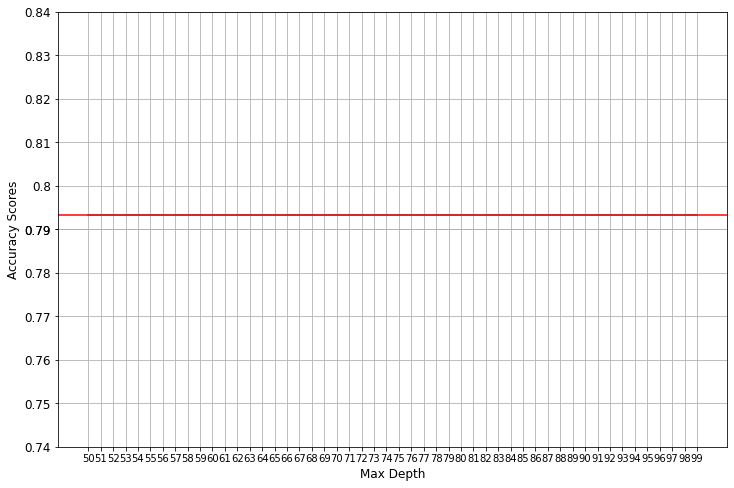

In [46]:
plt.figure(figsize=(12,8))
plt.plot(iters,acc_scores)
plt.axhline(max(acc_scores),color="red")

locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(acc_scores))
locs2= [round(num, 2) for num in locs2]

plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(iters, iters,fontsize=10)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)

plt.show()

In [47]:
from sklearn.naive_bayes import GaussianNB

dtc_bot = GaussianNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.20666666666666667 Accuracy Score: 0.7933333333333333 
 Confusion Matrix: 
 [[257  29]
 [ 95 219]] 



In [48]:
from sklearn.naive_bayes import MultinomialNB

dtc_bot = MultinomialNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.33166666666666667 Accuracy Score: 0.6683333333333333 
 Confusion Matrix: 
 [[262  24]
 [175 139]] 



In [49]:
from sklearn.naive_bayes import ComplementNB

dtc_bot = ComplementNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.45 Accuracy Score: 0.55 
 Confusion Matrix: 
 [[141 145]
 [125 189]] 



In [50]:
from sklearn.naive_bayes import BernoulliNB

dtc_bot = BernoulliNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.20666666666666667 Accuracy Score: 0.7933333333333333 
 Confusion Matrix: 
 [[257  29]
 [ 95 219]] 



In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
dtc=DecisionTreeClassifier()
# Train decision tree classifiers

max_depths = {'max_depth':[3,5,7,9,11]}
dtc_bot = GridSearchCV(dtc,max_depths, cv=5,scoring='precision',verbose=1, refit=True)
dtc_bot = dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;
print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
MSE: 0.20666666666666667 Accuracy Score: 0.7933333333333333 
 Confusion Matrix: 
 [[257  29]
 [ 95 219]] 



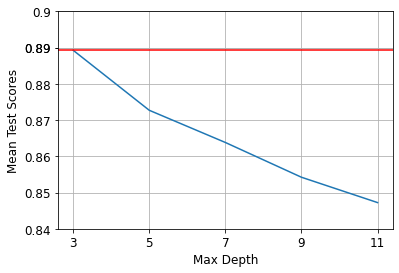

In [52]:
plt.plot(max_depths['max_depth'],dtc_bot.cv_results_['mean_test_score'])
plt.axhline(max(dtc_bot.cv_results_['mean_test_score']),color="red")
locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(dtc_bot.cv_results_['mean_test_score']))
locs2= [round(num, 2) for num in locs2]
plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(max_depths['max_depth'], max_depths['max_depth'],fontsize=12)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean Test Scores', fontsize=12)
plt.show()

In [53]:
print(best_accuracy_score)
dtc_political=best_dtc_model

0.7933333333333333


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [78]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [79]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,left_on='user_screen_name',right_on='screen_name')

dfBotAll_train

user_id                    user_name user_screen_name  \
0     1301168604667355142                    Doğabilim     dogabilimorg   
1               628886610               Esra Nur ÖZDEN  esranurmuratozd   
2               547532939                  Kübra Şakır        kubussskr   
3               946826934             Gökhan İZGİ 🇹🇷🇦🇿     gokhanizgi34   
4      802201284833067009                   Oral Orhon    orhonoral1975   
...                   ...                          ...              ...   
2827  1338444706204835840                  laito proof         vtaeskit   
2828            323513738                      Ezgobar        shaammone   
2829  1451270540669378572                   Havva Sert      havvasert19   
2830  1354034188815654912                         airi         airilynx   
2831            326232761  Türkiye Satranç Federasyonu     turkishchess   

            user_location                                   user_description  \
0                          Gerçek Bilginin Işığında!\nYayınlarımıza ulaşm...   
1                  Turkey  📍Güzeller güzeli 4 melek annesi\n📍Ak Parti Ank...   
2              iskenderun  'Allah'tan başka uğruna koştuğun hiçbir şey dü...   
3       İstanbul, Türkiye  📰 Gazeteci - Yazar  | 📘 S.O.S.YAL MEDYA kitabı...   
4       İstanbul, Türkiye  Holigan değil, sağlıklı ve Atatürkçü bir BEŞİK...   
...                   ...                                                ...   
2827  eu ar55 childe main                namjoon yalvaririm telefonlarimi ac   
2828                İzmir                                    humanoid 🏉 🏳️‍🌈   
2829                                                                           
2830        ♡🧷she/her 18   #mitski ; i start the day high and it ends so ...   
2831               Ankara  Türkiye Satranç Federasyonu Resmi Twitter Hesa...   

      user_followers_count  user_friends_count  description_len  \
0                      803                  93              109   
1                     1962                1650              134   
2                      531                 137               86   
3                    42188               33979              146   
4                     3988                4995               78   
...                    ...                 ...              ...   
2827                   270                 673               35   
2828                   521                 330               15   
2829                   155                 199                0   
2830                   712                 585               82   
2831                 12540                 540              100   

      followers_to_all_ratio  retweet_total_ratio  num_median_favorites  \
0                   0.896205             0.030000                   1.0   
1                   0.543189             0.985000                   0.0   
2                   0.794910             0.523560                   0.0   
3                   0.553888             0.320000                   1.0   
4                   0.443950             0.393939                   0.0   
...                      ...                  ...                   ...   
2827                0.286320             0.050000                   1.0   
2828                0.612221             0.025000                   1.0   
2829                0.437853             0.835052                   0.0   
2830                0.548959             0.120000                   1.0   
2831                0.958716             0.175000                  17.0   

     num_of_tweets mention_and_hashtagcount tweets_per_day      screen_name  \
0             None                     0.08       2.846154     dogabilimorg   
1             None                    1.865       9.526316  esranurmuratozd   
2             None                  1.91623       6.074074        kubussskr   
3             None                     1.25       0.587302     gokhanizgi34   
4             None                  0.79798           3

In [80]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

                  user_id                    user_name user_screen_name  \
0     1301168604667355142                    Doğabilim     dogabilimorg   
1               628886610               Esra Nur ÖZDEN  esranurmuratozd   
2               547532939                  Kübra Şakır        kubussskr   
3               946826934             Gökhan İZGİ 🇹🇷🇦🇿     gokhanizgi34   
4      802201284833067009                   Oral Orhon    orhonoral1975   
...                   ...                          ...              ...   
2827  1338444706204835840                  laito proof         vtaeskit   
2828            323513738                      Ezgobar        shaammone   
2829  1451270540669378572                   Havva Sert      havvasert19   
2830  1354034188815654912                         airi         airilynx   
2831            326232761  Türkiye Satranç Federasyonu     turkishchess   

            user_location                                   user_description  \
0                  

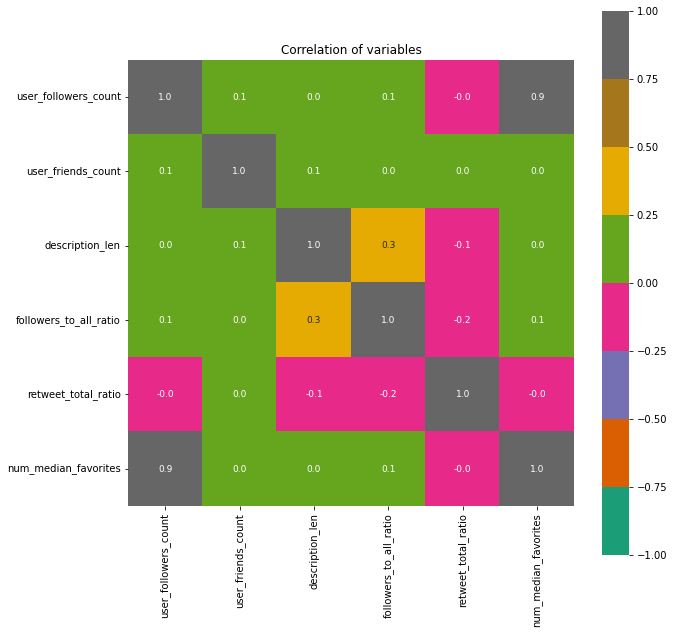

In [81]:
#Converting 'Yes' and 'No' to 1 and 0, respectively
dropped_dfBotAll_train=dfBotAll_train.copy()
dropped_dfBotAll_train['isBot'] = dropped_dfBotAll_train['isBot'].map({'Yes':1 ,'No':0})


#In this part, we found the correlations between variables by using heatmap
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title('Correlation of variables')

from sklearn.preprocessing import MinMaxScaler
msc = MinMaxScaler()
dropped_dfBotAll_train['mention_and_hashtagcount'] = msc.fit_transform(dropped_dfBotAll_train[['mention_and_hashtagcount']])
dropped_dfBotAll_train['tweets_per_day'] = msc.fit_transform(dropped_dfBotAll_train[['tweets_per_day']])
print(dropped_dfBotAll_train)
dropped_dfBotAll_train = dfBotAll_train.drop(['user_id', 'user_name','user_screen_name','user_location','user_description','num_of_tweets','screen_name'], axis = 1).corr()


sns.heatmap(dropped_dfBotAll_train, center=0, vmax=1, vmin=-1, annot = True, annot_kws = {'size':9},fmt='.1f',square=True,  cmap='Dark2')
plt.show()

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [82]:
#X = dfBotAll_train[['followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','mention_and_hashtagcount','tweets_per_day']]
X = dfBotAll_train[['followers_to_all_ratio', 'retweet_total_ratio', 'tweets_per_day','mention_and_hashtagcount']]
#X = dfBotAll_train[['retweet_total_ratio']]
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)
print(X[X.isna().any(axis=1)])

Empty DataFrame
Columns: [followers_to_all_ratio, retweet_total_ratio, tweets_per_day, mention_and_hashtagcount]
Index: []


### 2.2.3. Train-test split

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
#print(y_train[y_train.isna().any(axis=1)])

### 2.2.4. Train the model

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
best_accuracy_score= 0;

In [85]:
from sklearn.neighbors import KNeighborsClassifier
neighbors=range(1,40,1)
acc_scores=[]
for i in neighbors:
  dtc_bot= KNeighborsClassifier(n_neighbors=i)
  dtc_bot.fit(X_train, y_train)

  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_neighbor= neighbors[acc_scores.index(max(acc_scores))]
dtc_bot = KNeighborsClassifier(n_neighbors=best_neighbor)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.14991181657848324 
 Accuracy Score: 0.8500881834215167 
 Confusion Matrix: 
 [[472   7]
 [ 78  10]] 



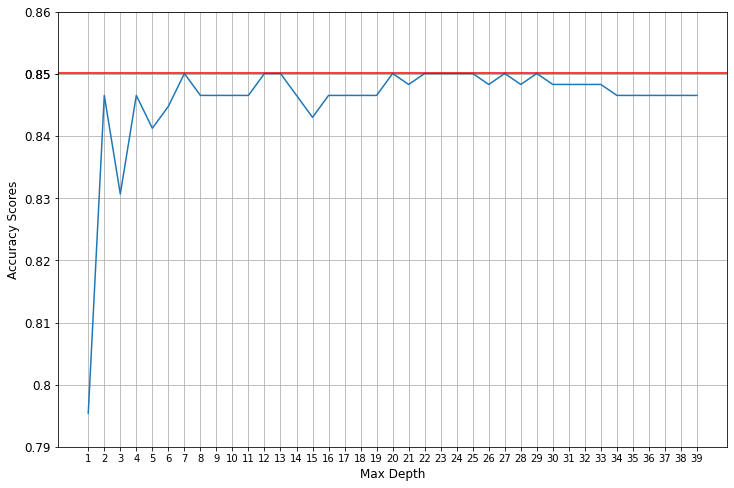

In [86]:
plt.figure(figsize=(12,8))
plt.plot(neighbors,acc_scores)
plt.axhline(max(acc_scores),color="red")

locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(acc_scores))
locs2= [round(num, 2) for num in locs2]

plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(neighbors, neighbors,fontsize=10)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)

plt.show()

In [87]:
from sklearn.tree import DecisionTreeClassifier

max_depths=range(3,20)
acc_scores=[]
for i in max_depths:
  # create an instance
  dtc_bot = DecisionTreeClassifier(max_depth=i)
  # fit your model
  dtc_bot.fit(X_train, y_train)
  # make predictions
  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_max_depth= max_depths[acc_scores.index(max(acc_scores))]
dtc_bot = DecisionTreeClassifier(max_depth=best_max_depth)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)

if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.14991181657848324 
 Accuracy Score: 0.8500881834215167 
 Confusion Matrix: 
 [[477   2]
 [ 83   5]] 



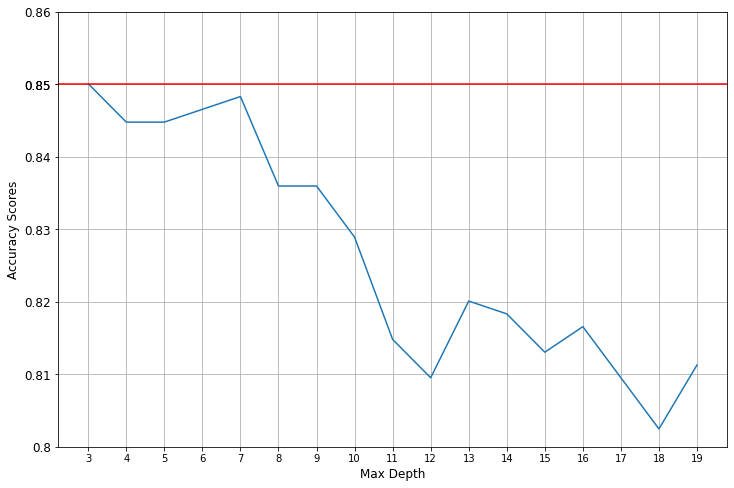

In [88]:
plt.figure(figsize=(12,8))
plt.plot(max_depths,acc_scores)
plt.axhline(max(acc_scores),color="red")

locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(acc_scores))
locs2= [round(num, 2) for num in locs2]

plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(max_depths, max_depths,fontsize=10)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)

plt.show()

In [89]:
from sklearn.linear_model import LogisticRegression

iters=range(50,100)
acc_scores=[]
for i in iters:
  # create an instance
  dtc_bot = LogisticRegression(max_iter=i)
  # fit your model
  dtc_bot.fit(X_train, y_train)
  # make predictions
  preds = dtc_bot.predict(X_valid)
  # evaluate on validation set
  acc_score = accuracy_score(y_valid, preds)
  confusion = confusion_matrix(y_valid, preds)
  acc_scores.append(acc_score)

best_max_iter= iters[acc_scores.index(max(acc_scores))]
dtc_bot = LogisticRegression(max_iter=best_max_iter)
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.15167548500881833 
 Accuracy Score: 0.8483245149911817 
 Confusion Matrix: 
 [[473   6]
 [ 80   8]] 



In [90]:
from sklearn.naive_bayes import GaussianNB

dtc_bot = GaussianNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.14109347442680775 
 Accuracy Score: 0.8589065255731922 
 Confusion Matrix: 
 [[463  16]
 [ 64  24]] 



In [91]:
from sklearn.naive_bayes import MultinomialNB

dtc_bot = MultinomialNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.16225749559082892 
 Accuracy Score: 0.8377425044091711 
 Confusion Matrix: 
 [[458  21]
 [ 71  17]] 



In [92]:
from sklearn.naive_bayes import ComplementNB

dtc_bot = ComplementNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.2786596119929453 
 Accuracy Score: 0.7213403880070547 
 Confusion Matrix: 
 [[374 105]
 [ 53  35]] 



In [93]:
from sklearn.naive_bayes import BernoulliNB

dtc_bot = BernoulliNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.15520282186948853 
 Accuracy Score: 0.8447971781305115 
 Confusion Matrix: 
 [[479   0]
 [ 88   0]] 



In [94]:
from sklearn.naive_bayes import CategoricalNB

dtc_bot = CategoricalNB()
dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;

print("MSE:", mse, "\n","Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")

MSE: 0.15167548500881833 
 Accuracy Score: 0.8483245149911817 
 Confusion Matrix: 
 [[465  14]
 [ 72  16]] 



In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
dtc=DecisionTreeClassifier()
# Train decision tree classifiers

max_depths = {'max_depth':[3,5,7,9,11]}
dtc_bot = GridSearchCV(dtc,max_depths, cv=5,scoring='precision',verbose=1, refit=True)
dtc_bot = dtc_bot.fit(X_train, y_train)
preds = dtc_bot.predict(X_valid)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse =mean_squared_error(y_valid, preds)
if(acc_score>best_accuracy_score):
  best_accuracy_score=acc_score
  best_dtc_model=dtc_bot;
print("MSE:",mse,"Accuracy Score:", acc_score, "\n","Confusion Matrix:", "\n", confusion, "\n")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
MSE: 0.14991181657848324 Accuracy Score: 0.8500881834215167 
 Confusion Matrix: 
 [[477   2]
 [ 83   5]] 



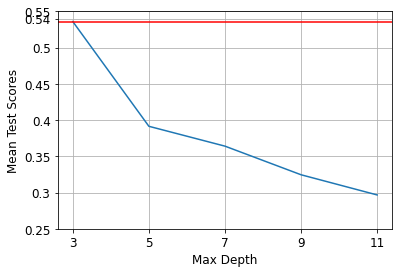

In [96]:
plt.plot(max_depths['max_depth'],dtc_bot.cv_results_['mean_test_score'])
plt.axhline(max(dtc_bot.cv_results_['mean_test_score']),color="red")
locs, labels =plt.yticks()
locs2= list(locs)
locs2.append(max(dtc_bot.cv_results_['mean_test_score']))
locs2= [round(num, 2) for num in locs2]
plt.yticks(locs2, locs2,fontsize=12)
plt.xticks(max_depths['max_depth'], max_depths['max_depth'],fontsize=12)
plt.grid(axis="both")
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean Test Scores', fontsize=12)
plt.show()

In [97]:
print(best_accuracy_score)

dtc_bot=best_dtc_model

0.8589065255731922


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [98]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('evaluation-round1-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags','is_retweet']]

# make predictions based on these variables
predictions_political = dtc_political.predict(X)

### This part is important! We expect you to return your predictions in the following format:

In [99]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.0,
 '1446578802507780102': 0.0,
 '1396859026705629191': 0.0,
 '1351058108651630593': 0.0,
 '1344910889741393920': 0.0,
 '1402216638926163968': 0.0,
 '1433340600544342016': 0.0,
 '1359234185819541505': 0.0,
 '1370134257490870273': 0.0,
 '1404914095254654985': 0.0,
 '1423390250932518912': 0.0,
 '1379103391561973776': 0.0,
 '1441887862262321152': 0.0,
 '1428477576436125697': 0.0,
 '1430964534865547267': 0.0,
 '1396099692392591369': 0.0,
 '1453457844834025482': 0.0,
 '1368522336543137795': 0.0,
 '1471136747916562432': 1.0,
 '1426676740659814403': 0.0,
 '1380989833452093440': 0.0,
 '1382055945849729026': 0.0,
 '1386220168293101570': 0.0,
 '1446955255971856387': 0.0,
 '1387932542804930560': 0.0,
 '1449557637318811660': 1.0,
 '1435612604278398979': 0.0,
 '1416447338202152965': 0.0,
 '1418854349451763714': 0.0,
 '1460256346624954371': 1.0,
 '1360961144769425411': 0.0,
 '1357077764533272577': 0.0,
 '1459738176520704002': 0.0,
 '1403968671425482754': 0.0,
 '144222984189

## 3.2. Predictions for Users (Bot or Not)

In [109]:
evaluationUserDf = pd.read_csv('evaluation-round1-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
#X = dfBot_test[['followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','mention_and_hashtagcount','tweets_per_day']]
X = dfBot_test[['followers_to_all_ratio', 'retweet_total_ratio', 'tweets_per_day','mention_and_hashtagcount']]
# make predictions based on these variables
predictions_bot = dtc_bot.predict(X)

In [110]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.0,
 'hazanguzel': 0.0,
 'alonedrummer': 0.0,
 'doktoramaaktor': 0.0,
 'muneccimsimge': 0.0,
 'koramzeynep': 0.0,
 'rabosscy': 0.0,
 'aykut190720': 0.0,
 'shadowoflower': 0.0,
 'adler16392917': 0.0,
 'alioztoprak06': 0.0,
 'ozk_emrullah': 0.0,
 'emineemiir': 0.0,
 'rsrsrs97': 0.0,
 'herseyeloji': 0.0,
 'eceemsoysal': 0.0,
 'viennabjk93': 0.0,
 'neogaymyback': 0.0,
 'av_abdurrahim': 0.0,
 'theinformavore': 0.0,
 'ahmetin93': 0.0,
 'neselibalkabagi': 0.0,
 'veckatimest': 0.0,
 'torbacisso': 0.0,
 'psychobutlogist': 0.0,
 'whiplashgirl_': 0.0,
 'senihadeyin': 0.0,
 'awwdizzy': 0.0,
 'suleymany4': 0.0,
 'canandrli': 1.0,
 'meloreco_recmel': 0.0,
 'limon99': 0.0,
 'odymsah': 0.0,
 'bagcebariscan': 0.0,
 'kasimileri_': 0.0,
 'dafemfairy': 0.0,
 'hadibak': 0.0,
 'laikmuhendis': 0.0,
 'aytacvehbi': 0.0,
 'f_pandaq': 0.0,
 'obanioglu': 0.0,
 'fbrepublicorg': 0.0,
 'mistikgucler1': 0.0,
 'cenkeroglu_1905': 0.0,
 'dcnp01': 0.0,
 'garciagala_': 0.0,
 'gokmenozcan': 0.0,
 'lovewi

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [106]:
with open('{}-round{}-tweet.txt'.format(STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))
    
    
with open('{}-round{}-user.txt'.format(STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredUser))

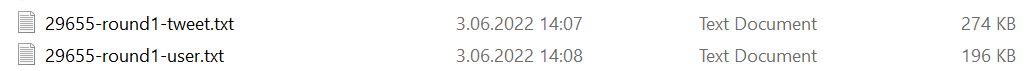

In [103]:
display.Image("https://i.imgur.com/lcwRsOW.png")

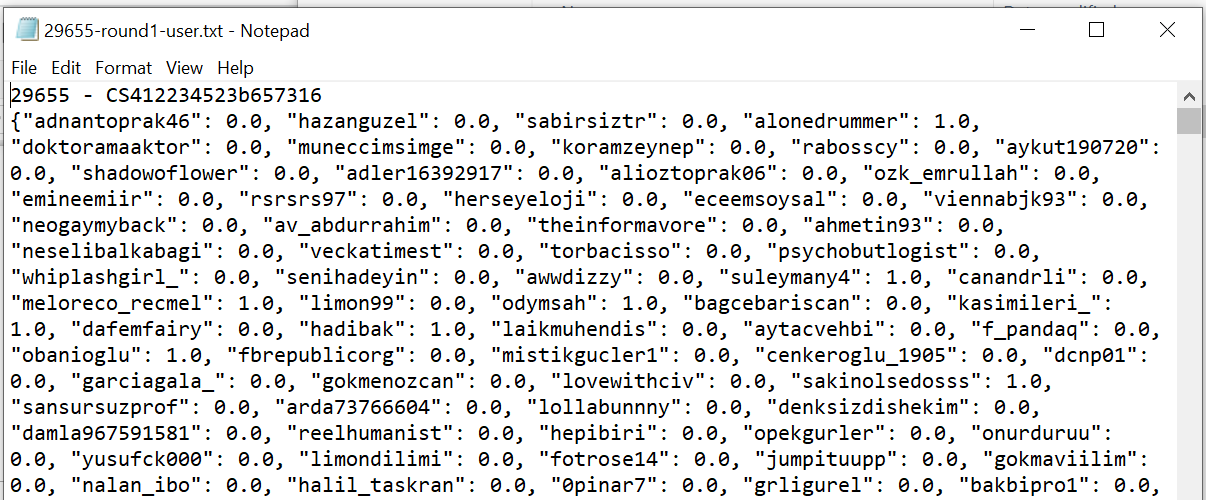

In [104]:
display.Image("https://i.imgur.com/qfxqgMF.png")

You can check whether you can read your predictions correctly or not:

In [105]:
with open('{}-round{}-tweet.txt'.format(STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])